In [4]:
from astropy.coordinates import SkyCoord
import numpy as np
from IntegralQuery import SearchQuery, IntegralQuery, Filter, Range
from IntegralPointingClustering import ClusteredQuery
import astropy.io.fits as fits
from astropy.table import Table
from pyspi.utils.response.spi_pointing import construct_sc_matrix, construct_scy
from pyspi.utils.geometry import cart2polar, polar2cart
from datetime import datetime
import matplotlib.pyplot as plt
import math
from numba import njit


In [5]:
# Lists of scw_ids for different date ranges

radius_around_crab = 3

p = SkyCoord(83.6333, 22.0144, frame="icrs", unit="deg")
searchquerry = SearchQuery(position=p, radius=f"{radius_around_crab} degree")
cat = IntegralQuery(searchquerry)

f1 = Filter(SCW_TYPE="POINTING",
            TIME=Range("2006-01-01T00:00:00", "2007-01-01T00:00:00"))
f2 = Filter(SCW_TYPE="POINTING",
            TIME=Range("2008-07-01T00:00:00", "2009-07-01T00:00:00"))
f3 = Filter(SCW_TYPE="POINTING",
            TIME=Range("2011-01-01T00:00:00", "2012-01-01T00:00:00"))
f4 = Filter(SCW_TYPE="POINTING",
            TIME=Range("2013-07-01T00:00:00", "2014-07-01T00:00:00"))
f5 = Filter(SCW_TYPE="POINTING",
            TIME=Range("2016-01-01T00:00:00", "2017-01-01T00:00:00"))


scw_ids1 = cat.apply_filter(f1, return_coordinates=True, remove_duplicates=True)
scw_ids2 = cat.apply_filter(f2, return_coordinates=True, remove_duplicates=True)
scw_ids3 = cat.apply_filter(f3, return_coordinates=True, remove_duplicates=True)
scw_ids4 = cat.apply_filter(f4, return_coordinates=True, remove_duplicates=True)
scw_ids5 = cat.apply_filter(f5, return_coordinates=True, remove_duplicates=True)

In [6]:
# Clusters of size 2

min_angle_dif = 2.0
max_angle_dif = 2.5
max_time_dif = 0.3

cq1 = ClusteredQuery(scw_ids1,
                    angle_weight=0.,
                    time_weight=1./max_time_dif,
                    max_distance=1.,
                    min_ang_distance=min_angle_dif,
                    max_ang_distance=max_angle_dif,
                    cluster_size_range = (2,2),
                    failed_improvements_max = 3,
                    suboptimal_cluster_size = 1,
                    close_suboptimal_cluster_size = 1).get_clustered_scw_ids()
cq2 = ClusteredQuery(scw_ids2,
                    angle_weight=0.,
                    time_weight=1./max_time_dif,
                    max_distance=1.,
                    min_ang_distance=min_angle_dif,
                    max_ang_distance=max_angle_dif,
                    cluster_size_range = (2,2),
                    failed_improvements_max = 3,
                    suboptimal_cluster_size = 1,
                    close_suboptimal_cluster_size = 1).get_clustered_scw_ids()
cq3 = ClusteredQuery(scw_ids3,
                    angle_weight=0.,
                    time_weight=1./max_time_dif,
                    max_distance=1.,
                    min_ang_distance=min_angle_dif,
                    max_ang_distance=max_angle_dif,
                    cluster_size_range = (2,2),
                    failed_improvements_max = 3,
                    suboptimal_cluster_size = 1,
                    close_suboptimal_cluster_size = 1).get_clustered_scw_ids()
cq4 = ClusteredQuery(scw_ids4,
                    angle_weight=0.,
                    time_weight=1./max_time_dif,
                    max_distance=1.,
                    min_ang_distance=min_angle_dif,
                    max_ang_distance=max_angle_dif,
                    cluster_size_range = (2,2),
                    failed_improvements_max = 3,
                    suboptimal_cluster_size = 1,
                    close_suboptimal_cluster_size = 1).get_clustered_scw_ids()
cq5 = ClusteredQuery(scw_ids5,
                    angle_weight=0.,
                    time_weight=1./max_time_dif,
                    max_distance=1.,
                    min_ang_distance=min_angle_dif,
                    max_ang_distance=max_angle_dif,
                    cluster_size_range = (2,2),
                    failed_improvements_max = 3,
                    suboptimal_cluster_size = 1,
                    close_suboptimal_cluster_size = 1).get_clustered_scw_ids()

cluster1 = cq1[2][0] #['042200080010', '042200150010']
cluster2 = cq2[2][0] #['072700090010', '072700140010']
cluster3 = cq3[2][0] #['164400170010', '164400160010']
cluster4 = cq4[2][0] #['132700090010', '132700140010']
cluster5 = cq5[2][0] #['164400150010', '164400220010']

print(cluster1, cluster2, cluster3, cluster4, cluster5)
# Expect: ['042200080010', '042200150010'] ['072700090010', '072700140010'] 
# ['101900600010', '101900650010'] ['132700090010', '132700140010'] ['164400150010', '164400220010']

['042200080010', '042200150010'] ['072700090010', '072700140010'] ['101900600010', '101900650010'] ['132700090010', '132700140010'] ['164400150010', '164400220010']


In [7]:
# Compare pointing coordinates

# Load all necessary data
pointing_id1 = cluster1[0]
pointing_id2 = cluster1[1]

from astroquery.heasarc import Heasarc, Conf
integral_query = Heasarc()
Conf.server.set('https://www.isdc.unige.ch/browse/w3query.pl')
query_dict = {}
query_dict["mission"] = "integral_rev3_scw"
query_dict["position"] = p
query_dict["radius"] = f"{radius_around_crab} degree"
query_dict["sortvar"] = "START_DATE"
query_dict["resultmax"] = 0
r = integral_query.query_region(**query_dict)
r.convert_bytestring_to_unicode()
pa = r.to_pandas()
pointing_heasarc_info1 = pa[pa["SCW_ID"]==pointing_id1]
pointing_heasarc_info2 = pa[pa["SCW_ID"]==pointing_id2]


with fits.open("crab_data/0422/pointing.fits") as file:
    t = Table.read(file[1])
    pointing_fits_info1 = t[t["PTID_ISOC"]==pointing_id1[:8]]
    pointing_fits_info2 = t[t["PTID_ISOC"]==pointing_id2[:8]]


# Start and End Times
# See https://www.isdc.unige.ch/integral/support/faq.cgi?DATA-007
import astropy.time as at
print(f"Pointing {pointing_id1}")
print("HEASARC times:") 
print(f"{pointing_heasarc_info1['START_DATE'].iloc[0]} to {pointing_heasarc_info1['END_DATE'].iloc[0]}")
print("Fits times:")
print(f'''{at.Time(f'{pointing_fits_info1["TSTART"][0]+2451544.5}', format='jd').iso[:-4]} to {at.Time(f'{pointing_fits_info1["TSTOP"][0]+2451544.5}', format='jd').iso[:-4]}''')
print()
print(f"Pointing {pointing_id2}")
print("HEASARC times:") 
print(f"{pointing_heasarc_info2['START_DATE'].iloc[0]} to {pointing_heasarc_info2['END_DATE'].iloc[0]}")
print("Fits times:")
print(f'''{at.Time(f'{pointing_fits_info2["TSTART"][0]+2451544.5}', format='jd').iso[:-4]} to {at.Time(f'{pointing_fits_info2["TSTOP"][0]+2451544.5}', format='jd').iso[:-4]}''')

print()
print(
    "The Fits times are in TT, which differ from UTC by 00:01:05. "
    "If the HEASARC times are in UTC, then SCW 042200150010 matches perfectly. "
    "Generally speaking, the time difference between the times given by HEASARC and those in the fits files is "
    "inconsistent, with science windows usually being a little shorter using the fits times. "
    "When in disagreement, I suppose the times in the fits files are preferable."
)
print()
print()


# SPI Orientation
# Get misalignment matrix
from pyspi.io.package_data import get_path_of_internal_data_dir
matrix_file = os.path.join(get_path_of_internal_data_dir(), 'inst_misalign_20050328.fits')
with fits.open(matrix_file) as f:
    spi_idx = f['GNRL-IROT-MOD'].data['INSTRUMENT'] == 'SPI'
    matrix_raw = f['GNRL-IROT-MOD'].data['MATRIX'][spi_idx]
    misalignment_matrix = matrix_raw.reshape((3,3))
    iv_mm = np.linalg.inv(misalignment_matrix)

# Calculate INTEGRAL coordinates from SPI coordinates
rax1, decx1, raz1, decz1 = pointing_fits_info1["RA_SPIX", "DEC_SPIX", "RA_SPIZ", "DEC_SPIZ"].as_array()[0]
ray1, decy1 = construct_scy(rax1, decx1, raz1, decz1)
sc_matrix1 = construct_sc_matrix(rax1, decx1, ray1, decy1, raz1, decz1)
ic_matrix1 = np.dot(iv_mm, sc_matrix1)
irax1, idecx1 = cart2polar(ic_matrix1[0, : ])

# Compare results
print(f"Pointing {pointing_id1}")
print("HEASARC x-orientation:") 
print(f"{pointing_heasarc_info1['RA_X'].iloc[0]}, {pointing_heasarc_info1['DEC_X'].iloc[0]}")
print("Fits x-orientation:")
print(f"{irax1:.6f}, {idecx1:.6f}")
print()

# Repeat for second pointing
rax2, decx2, raz2, decz2 = pointing_fits_info2["RA_SPIX", "DEC_SPIX", "RA_SPIZ", "DEC_SPIZ"].as_array()[0]
ray2, decy2 = construct_scy(rax2, decx2, raz2, decz2)
sc_matrix2 = construct_sc_matrix(rax2, decx2, ray2, decy2, raz2, decz2)
ic_matrix2 = np.dot(iv_mm, sc_matrix2)
irax2, idecx2 = cart2polar(ic_matrix2[0, : ])

print(f"Pointing {pointing_id2}")
print("HEASARC x-orientation:") 
print(f"{pointing_heasarc_info2['RA_X'].iloc[0]}, {pointing_heasarc_info2['DEC_X'].iloc[0]}")
print("Fits x-orientation:")
print(f"{irax2:.6f}, {idecx2:.6f}")
print()
print(
    "The orientation coordinates in the HEASARC Query thus specify the orientation of INTEGRAL, and not SPI. "
    "This may prove to be problematic if we wish for precise requirements in the clustering algorithm."
)

Pointing 042200080010
HEASARC times:
2006-03-28 20:40:15 to 2006-03-28 21:10:15
Fits times:
2006-03-28 20:42:08 to 2006-03-28 21:11:26

Pointing 042200150010
HEASARC times:
2006-03-29 00:24:32 to 2006-03-29 00:54:33
Fits times:
2006-03-29 00:25:37 to 2006-03-29 00:55:38

The Fits times are in TT, which differ from UTC by 00:01:05. If the HEASARC times are in UTC, then SCW 042200150010 matches perfectly. Generally speaking, the time difference between the times given by HEASARC and those in the fits files is inconsistent, with science windows usually being a little shorter using the fits times. When in disagreement, I suppose the times in the fits files are preferable.




Pointing 042200080010
HEASARC x-orientation:
80.854958, 23.445110
Fits x-orientation:
80.854956, 23.445110

Pointing 042200150010
HEASARC x-orientation:
82.973495, 23.935888
Fits x-orientation:
82.973496, 23.935888

The orientation coordinates in the HEASARC Query thus specify the orientation of INTEGRAL, and not SPI. This may prove to be problematic if we wish for precise requirements in the clustering algorithm.


In [11]:
#from re import S
import astropy.time as at
def extract_relevant_information(path, p_id):
    num_dets = 19
    with fits.open(f"{path}/pointing.fits") as file:
        t = Table.read(file[1])
        index = np.argwhere(t["PTID_ISOC"]==p_id[:8])

        time_elapsed = 0.
        for i in index:
            pointing_info = t[i[0]]
            
            t1 = at.Time(f'{pointing_info["TSTART"]+2451544.5}', format='jd').datetime
            time_start = datetime.strftime(t1,'%y%m%d %H%M%S')
            
    with fits.open(f"{path}/dead_time.fits") as file:
        t = Table.read(file[1])
        
        time_elapsed = np.zeros(num_dets)
        
        for i in range(num_dets):
            for j in index:
                time_elapsed[i] += t["LIVETIME"][j[0]*85 + i]
        
    with fits.open(f"{path}/energy_boundaries.fits") as file:
        t = Table.read(file[1])
        
        energy_bins = np.append(t["E_MIN"], t["E_MAX"][-1])
    
    with fits.open(f"{path}/evts_det_spec.fits") as file:
        t = Table.read(file[1])
        
        counts = np.zeros((num_dets, len(energy_bins)-1))
        for i in range(num_dets):
            for j in index:
                counts[i, : ] += t["COUNTS"][j[0]*85 + i]

    return time_start, time_elapsed, energy_bins, counts


def rebin_data_full(energy_bins, counts, min_counts, max_num_bins = None):
    max_num_bins = max_num_bins if max_num_bins else len(energy_bins)
    min_num_bins = 1
    
    finished = False
    
    while not finished:
        num_bins = round((max_num_bins + min_num_bins) / 2)
        
        if num_bins == max_num_bins or num_bins == min_num_bins:
            num_bins = min_num_bins
            finished = True
        
        new_bins = np.geomspace(energy_bins[0], energy_bins[-1], num_bins+1)
        
        new_counts = rebin_data(energy_bins, counts, new_bins)
        
        if np.amin(new_counts) < min_counts:
            max_num_bins = num_bins
        else:
            min_num_bins = num_bins
            
    return new_bins, new_counts
    
@njit
def rebin_data(energy_bins, counts, new_energy_bins):
    new_counts = np.zeros((counts.shape[0], len(new_energy_bins)-1))
    
    def enter_bins_smaller(i, bin):
        split = ((energy_bins[bin+1] - max(energy_bins[bin], new_energy_bins[i]))
                 / (energy_bins[bin+1] - energy_bins[bin]))
        new_counts[ : , i] += counts[ : , bin] * split
    
    bin = 0
    length = len(energy_bins) - 1
    for i in range(len(new_energy_bins)-1):
        
        while new_energy_bins[i+1] > energy_bins[bin+1]:
            enter_bins_smaller(i, bin)
            bin += 1
        
        if new_energy_bins[i+1] == energy_bins[bin+1]:
            enter_bins_smaller(i, bin)
            bin += 1
        
        else:
            split = ((min(energy_bins[bin+1], new_energy_bins[i+1]) - max(energy_bins[bin], new_energy_bins[i]))
                     / (energy_bins[bin+1] - energy_bins[bin]))
            new_counts[ : , i] += counts[ : , bin] * split
            
    return new_counts

In [12]:
from pyspi.utils.function_utils import find_response_version
from pyspi.utils.response.spi_response_data import ResponseDataRMF
from pyspi.utils.response.spi_response import ResponseRMFGenerator
from pyspi.utils.response.spi_drm import SPIDRM
from pyspi.utils.livedets import get_live_dets
from astromodels import Powerlaw, Log_uniform_prior, Uniform_prior, PointSource, SpectralComponent


def fit_crab_2_pointings(pointings):
    # example: pointings = (("crab_data/0422", "042200080010", '042200150010'),
    #                       ("crab_data/1019", "101900600010", '101900650010'))
    
    emod = np.geomspace(18,3000,50)
    counts = []
    dets = []
    resp_mats = []
    t_elapsed = []
    
    ra_crab, dec_crab = 83.6333, 22.0144
    min_counts = 5
    max_num_bins = 300
    
    for count, pair in enumerate(pointings):
        time_start1, time_elapsed1, energy_bins1, counts_f1 = extract_relevant_information(pair[0], pair[1])
        time_start2, time_elapsed2, energy_bins2, counts_f2 = extract_relevant_information(pair[0], pair[2])
        
        
        version1 = find_response_version(time_start1)
        version2 = find_response_version(time_start2)
        assert version1 == version2, f"Response versions are not equal for {pair[0]}"
        
        dets1 = get_live_dets(time=time_start1, event_types=["single"])
        dets2 = get_live_dets(time=time_start2, event_types=["single"])
        assert np.array_equal(dets1, dets2), f"Active detectors are not the same for {pair[0]}"
        dets.append(dets1)
        
        t_elapsed.append((time_elapsed1[dets1], time_elapsed2[dets1]))
        
        assert np.array_equal(energy_bins1, energy_bins2), f"Energy bins are not the same for {pair[0]}"
        eb, c = rebin_data_full(energy_bins1,
                                np.append(counts_f1[dets1], counts_f2[dets1], axis=0),
                                min_counts,
                                max_num_bins)
        counts.append((c[:len(dets1)], c[len(dets1):]))
        
        rsp_base = ResponseDataRMF.from_version(version1)
        sds1 = np.array([])
        sds2 = np.array([])
        for d in dets1:
            rsp1 = ResponseRMFGenerator.from_time(time_start1, d, eb, emod, rsp_base)
            sd1 = SPIDRM(rsp1, ra_crab, dec_crab)
            sds1 = np.append(sds1, sd1.matrix.T)
            rsp2 = ResponseRMFGenerator.from_time(time_start2, d, eb, emod, rsp_base)
            sd2 = SPIDRM(rsp2, ra_crab, dec_crab)
            sds2 = np.append(sds2, sd2.matrix.T)
        resp_mats.append((
            sds1.reshape((len(dets1), len(emod)-1, len(eb)-1)),
            sds2.reshape((len(dets1), len(emod)-1, len(eb)-1)),
        ))
        
    counts = tuple(counts)
    dets = tuple(dets)
    resp_mats = tuple(resp_mats)
    t_elapsed = tuple(t_elapsed)
        
    pl = Powerlaw()
    pl.index = -2.08
    pl.K = 9.3#6.44*10**-4
    pl.xiv = 1
    pl.K.prior = Log_uniform_prior(lower_bound=0.001, upper_bound=1000)
    pl.index.prior = Uniform_prior(lower_bound=-4, upper_bound=0)
    component1 = SpectralComponent('pl',shape=pl)
    ps = PointSource('plline',ra=ra_crab, dec=dec_crab, components=[component1])
    
    @njit
    def bmaxba(m1, m2, t1, t2, C1, C2):
        first = C1+C2-(m1+m2)*(t1+t2)
        root = (C1+C2+(m1-m2)*(t1+t2))**2-4*C1*(m1-m2)*(t1+t2)
        res = (first+np.sqrt(root))/(2*(t1+t2))
        if res < 0:
            return 0
        return res
    
    @njit
    def logLcore(spec_binned):
        logL=0
        for k in range(len(pointings)):
            for j in range(len(dets[k])):
                m1 = np.dot(spec_binned[k], resp_mats[k][0][j])
                m2 = np.dot(spec_binned[k], resp_mats[k][1][j])
                for i in range(len(m1)):
                    bm = bmaxba(m1[i], m2[i], t_elapsed[k][0][j], t_elapsed[k][1][j], counts[k][0][j, i], counts[k][1][j, i])
                    logL += (counts[k][0][j, i]*math.log(t_elapsed[k][0][j]*(m1[i]+bm))+
                            counts[k][1][j, i]*math.log(t_elapsed[k][1][j]*(m2[i]+bm))-
                            t_elapsed[k][0][j]*(m1[i]+bm)-
                            t_elapsed[k][1][j]*(m2[i]+bm))
        return logL
    
    # spec_binned = np.zeros((len(pointings), len(emod)-1))
    # for i in range(len(pointings)):
    #     spec = pl(emod)
    #     spec_binned[i,:] = (emod[1:]-emod[:-1])*(spec[:-1]+spec[1:])/2
        
    # return logLcore(spec_binned)

    def logLba_mult(trial_values, ndim=None, params=None):
        pl.index = trial_values[1]
        pl.K = trial_values[0]
        spec_binned = np.zeros((len(pointings), len(emod)-1))
        for i in range(len(pointings)):
            spec = pl(emod)
            spec_binned[i,:] = (emod[1:]-emod[:-1])*(spec[:-1]+spec[1:])/2
        return logLcore(spec_binned)
    
    def prior(params, ndim=None, nparams=None):
        for i, (parameter_name, parameter) in enumerate(
            ps.free_parameters.items()
        ):
            try:
                params[i] = parameter.prior.from_unit_cube(params[i])

            except AttributeError:
                raise RuntimeError(
                    "The prior you are trying to use for parameter %s is "
                    "not compatible with sampling from a unitcube"
                    % parameter_name
                )


    
    import pymultinest
    import os
    if not os.path.exists("./chains"):
        os.mkdir("chains")
    sampler = pymultinest.run(
                        logLba_mult, prior, 2, 2, n_live_points=800, resume=False, verbose=True
                    )
    
    %matplotlib inline
    from chainconsumer import ChainConsumer


    def loadtxt2d(intext):
            try:
                return np.loadtxt(intext, ndmin=2)
            except:
                return np.loadtxt(intext)

    c = ChainConsumer()

    chain = loadtxt2d('./chains/1-post_equal_weights.dat')

    #c.add_chain(chain, parameters=['K', 'index', 'F', 'mu','sigma', '$z$'], name='yeah')
    c.add_chain(chain, parameters=['K', 'index', '$z$'], name='fit')
    
    c.plotter.plot(filename="crab_parameter_fit.pdf", 
                parameters=['K', 'index'],
                truth=[9.3, -2.08],
                log_scales=[]);
    
    
    
    
    
    
    
    



Using the irfs that are valid between 04/07/17 08:20:06 and 09/02/19 09:59:57 (YY/MM/DD HH:MM:SS)
Using the irfs that are valid between 04/07/17 08:20:06 and 09/02/19 09:59:57 (YY/MM/DD HH:MM:SS)
Using the irfs that are valid between 10/05/27 12:45:00 and present (YY/MM/DD HH:MM:SS)
Using the irfs that are valid between 10/05/27 12:45:00 and present (YY/MM/DD HH:MM:SS)
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  800
 dimensionality =    2
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.996483
Replacements:                                850
Total Samples:                               853
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.999414
Acceptance Rate:                        0.993377


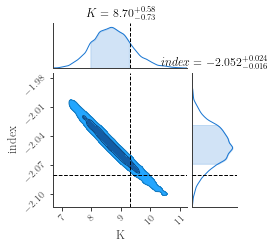

In [21]:
pointings = (("crab_data/0422", "042200080010", '042200150010'),
             ("crab_data/0422", "042200080010", '042200150010'),
            #  ("crab_data/1019", "101900600010", '101900650010'),
             ("crab_data/1327", '132700090010', '132700140010'),
             ("crab_data/1644", '164400150010', '164400220010'))



fit_crab_2_pointings(pointings)

Using the irfs that are valid between 04/07/17 08:20:06 and 09/02/19 09:59:57 (YY/MM/DD HH:MM:SS)
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  800
 dimensionality =    2
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.996483
Replacements:                                850
Total Samples:                               853
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.998934
Acceptance Rate:                        0.991189
Replacements:                                900
Total Samples:                               908
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.998966
Acceptance Rate:                        0.980392
Replacements:  

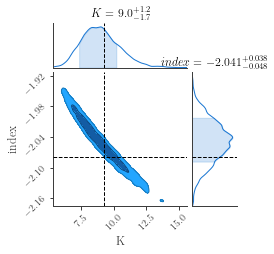

In [15]:
pointings = (("crab_data/0422", "042200080010", '042200150010'),)
fit_crab_2_pointings(pointings)

Using the irfs that are valid between 04/07/17 08:20:06 and 09/02/19 09:59:57 (YY/MM/DD HH:MM:SS)
AFS data access did not work. I will try the ISDC data archive.
AFS data access did not work. I will try the ISDC data archive.
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  800
 dimensionality =    2
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.998825
Replacements:                                850
Total Samples:                               851
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.911839
Acceptance Rate:                        0.992282
Replacements:                                900
Total Samples:                               907
Nested Sampling ln(Z):            **************

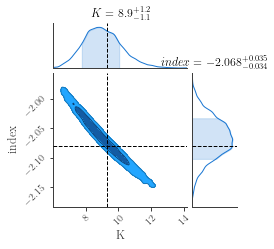

In [17]:
pointings = (("crab_data/0727", '072700090010', '072700140010'),)
fit_crab_2_pointings(pointings)

Using the irfs that are valid between 10/05/27 12:45:00 and present (YY/MM/DD HH:MM:SS)
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  800
 dimensionality =    2
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        1.000000
Replacements:                                850
Total Samples:                               850
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.998013
Acceptance Rate:                        0.996678
Replacements:                                900
Total Samples:                               903
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.998047
Acceptance Rate:                        0.991649
Replacements:            

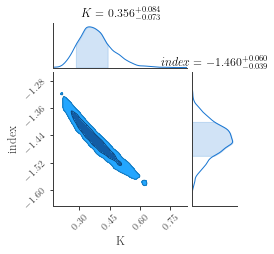

In [16]:
pointings = (("crab_data/1019", "101900600010", '101900650010'),)
fit_crab_2_pointings(pointings)

Using the irfs that are valid between 10/05/27 12:45:00 and present (YY/MM/DD HH:MM:SS)
AFS data access did not work. I will try the ISDC data archive.
AFS data access did not work. I will try the ISDC data archive.
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  800
 dimensionality =    2
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.998825
Replacements:                                850
Total Samples:                               851
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.999411
Acceptance Rate:                        0.991189
Replacements:                                900
Total Samples:                               908
Nested Sampling ln(Z):            **************
Importanc

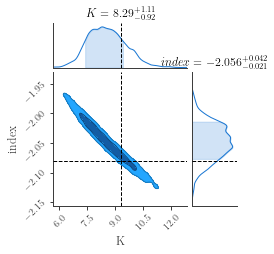

In [18]:
pointings = (("crab_data/1327", '132700090010', '132700140010'),)
fit_crab_2_pointings(pointings)

Using the irfs that are valid between 10/05/27 12:45:00 and present (YY/MM/DD HH:MM:SS)
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  800
 dimensionality =    2
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.996483
Replacements:                                850
Total Samples:                               853
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.999413
Acceptance Rate:                        0.992282
Replacements:                                900
Total Samples:                               907
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.999448
Acceptance Rate:                        0.982420
Replacements:            

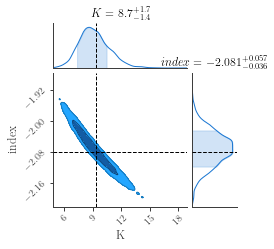

In [19]:
pointings = (("crab_data/1644", '164400150010', '164400220010'),)
fit_crab_2_pointings(pointings)